# IMPORTS + UTILS

### Propósito
Utilidades para evaluar clasificación binaria de imágenes (por ejemplo, *bird vs. nobird*) con PyTorch. Incluye funciones para reproducibilidad, búsqueda de umbral, cálculo de métricas, matriz de confusión y alineación de *scores* externos (como YOLO) con `ImageFolder`.

---

### Instalación e imports
Instala PyTorch (CUDA opcional), Ultralytics, FiftyOne y Seaborn.  
Importa NumPy, Pandas, PyTorch/Torchvision, Matplotlib/Seaborn, scikit-learn (métricas) y statsmodels (McNemar).  
Se silencian *warnings* para un entorno limpio.

---

### Reproducibilidad — `set_seed`
Fija semillas en `random`, `numpy` y `torch` (CPU/GPU) para asegurar resultados reproducibles.

---

### Umbral óptimo — `best_threshold`
Explora valores en `[0, 0.995]` y selecciona el umbral que maximiza la **accuracy** sobre los *scores* (probabilidades del modelo).

---

### Métricas desde predicciones — `metrics_from_pred`
Calcula y devuelve **accuracy**, **precision**, **recall**, **F1** y la **matriz de confusión** a partir de predicciones binarias.

---

### Métricas desde *scores* — `metrics_from_score`
Encuentra el umbral óptimo, binariza los *scores*, calcula métricas, imprime un resumen y retorna un diccionario con `th`, `pred`, `cm` y `score`.

---

### Matriz de confusión — `plot_cm`
Genera dos gráficos de la matriz de confusión:  
1. **Absoluta (conteos)**  
2. **Normalizada por filas (%)**  
Incluye etiquetas claras y usa `tight_layout()` para evitar solapes.

---

### Alineación de *scores* externos — `check_alignment`
Alinea los *scores* (por ejemplo, de YOLO) con el orden de `val_ds.samples`.  
Verifica que `1 = bird`, maneja faltantes con 0.0 y limpia valores `NaN` o `Inf`.  
Devuelve `(ys_alineado, scores_alineados)` listos para evaluación.

In [1]:
# ==================== IMPORTS Y METODOS ====================

!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install ultralytics fiftyone seaborn

import os, math, random, warnings
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from statsmodels.stats.contingency_tables import mcnemar

warnings.filterwarnings("ignore")

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def best_threshold(y_true, score, n_grid=200):
    ths = np.linspace(0, 0.995, n_grid)
    accs = [np.mean(y_true == (score >= t).astype(int)) for t in ths]
    i = int(np.argmax(accs))
    return float(ths[i]), float(accs[i])

def metrics_from_pred(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return acc, prec, rec, f1, cm

def metrics_from_score(y_true, score, name="model"):
    th, _ = best_threshold(y_true, score)
    y_pred = (score >= th).astype(int)
    acc, prec, rec, f1, cm = metrics_from_pred(y_true, y_pred)
    print(f"[{name}] ACC={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f} | th={th:.3f}")
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "th":th, "pred":y_pred, "cm":cm, "score":score}

def plot_cm(cm, title):
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: nobird','Pred: bird'],
                yticklabels=['Real: nobird','Real: bird'], ax=ax[0])
    ax[0].set_title(f'{title} (abs)'); ax[0].set_xlabel('Predicción'); ax[0].set_ylabel('Etiqueta real')
    sns.heatmap(cm_norm*100, annot=True, fmt='.1f', cmap='Greens', cbar=False,
                xticklabels=['Pred: nobird','Pred: bird'],
                yticklabels=['Real: nobird','Real: bird'], ax=ax[1])
    ax[1].set_title(f'{title} (%)'); ax[1].set_xlabel('Predicción'); ax[1].set_ylabel('Etiqueta real')
    plt.tight_layout(); plt.show()

def check_alignment(val_ds, bird_idx, ys, yolo_scores, yolo_files_order=None):
    """Alinea y valida que yolo_scores correspondan a val_ds.samples y que ys=1 sea bird."""
    y_true = np.array([1 if cls == bird_idx else 0 for _, cls in val_ds.samples], dtype=int)
    if ys is None:
        ys = y_true.copy()
    else:
        diff = int(np.abs(ys.astype(int) - y_true).sum())
        if diff != 0:
            print(f"[WARN] ys no coinciden con val_ds.samples ({diff} desalineados). Se sustituye por y_true canónico.")
            ys = y_true.copy()

    val_files_truth = [Path(s[0]).as_posix() for s in val_ds.samples]
    if yolo_files_order is None:
        yolo_files_order = val_files_truth[:]
    idx_map = {Path(p).as_posix(): i for i, p in enumerate(yolo_files_order)}
    yolo_aligned = np.zeros(len(val_files_truth), dtype=float)
    missing = []
    for i, p in enumerate(val_files_truth):
        j = idx_map.get(p, None)
        if j is None:
            missing.append(p); yolo_aligned[i] = 0.0
        else:
            yolo_aligned[i] = float(yolo_scores[j])
    if missing:
        print(f"[WARN] {len(missing)} archivos de VAL faltaron en YOLO. Se asignó 0.0")
    bad = np.isnan(yolo_aligned) | np.isinf(yolo_aligned)
    if bad.any():
        print(f"[WARN] {bad.sum()} NaN/Inf en YOLO → 0.0")
        yolo_aligned[bad] = 0.0
    yolo_aligned = np.clip(yolo_aligned, 0.0, 1.0)
    return ys.astype(int), yolo_aligned


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.1/307.1 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.3 MB/s eta 0:0

# RUTAS + DATASETS + LOADERS

### Rutas, datasets y cargadores de datos

En este bloque se configuran las rutas base del dataset, los parámetros globales de entrenamiento y los **DataLoaders** para PyTorch.

---

#### Configuración inicial
- Se fija una semilla (`set_seed(42)`) para asegurar reproducibilidad.  
- Si el entorno es Google Colab, se monta Google Drive para acceder al dataset.  
- Se detecta el dispositivo de cómputo (`cuda` si hay GPU, de lo contrario `cpu`).

---

#### Directorios y validación
Define la estructura base del dataset:
- `BASE` apunta a la carpeta principal (`/content/drive/MyDrive/openimages_v7`).  
- `TRAIN_DIR` y `VAL_DIR` contienen las carpetas `bird` y `nobird`.  
El código verifica que todas las rutas existan antes de continuar.

---

#### Parámetros de entrenamiento
Se establecen variables globales:
- `IMG_SIZE`: tamaño de las imágenes.  
- `BATCH`: tamaño de lote, ajustado según GPU/CPU.  
- `NUM_WORK`: número de *workers* en el *DataLoader*.  
- `WD`, `LR_A/B`, `EPOCHS_A/B`, `PATIENCE_A/B`: hiperparámetros comunes (weight decay, learning rate, épocas y paciencia del early stopping).

---

#### Transformaciones de datos
- **Entrenamiento (`train_tf`)**: recorte aleatorio, volteo horizontal y ajuste de color para aumentar la variabilidad (data augmentation).  
- **Validación (`val_tf`)**: redimensionado y recorte centrado, sin aleatoriedad, para evaluar de forma consistente.

Ambas transformaciones normalizan los valores con los promedios y desviaciones estándar de *ImageNet*.

---

#### Datasets y clases
Crea los datasets `train_ds` y `val_ds` usando `ImageFolder`, que infiere automáticamente las clases desde las carpetas.  
Se imprime la correspondencia de clases y se guarda el índice de la clase *bird* (`bird_idx`).

---

#### Balanceo de clases
Para evitar sesgos por desbalance entre clases:
1. Se calculan las frecuencias de cada clase (`class_counts`).  
2. Se asignan pesos inversos a cada clase (`class_weights`).  
3. Se usa `WeightedRandomSampler` para muestrear las imágenes con probabilidad inversa a su frecuencia.

---

#### DataLoaders
Crea los cargadores `train_dl` y `val_dl`:
- `train_dl`: usa el *sampler* ponderado para equilibrar las clases.  
- `val_dl`: desactiva el *shuffle* para mantener orden fijo.  
Ambos cargadores usan `pin_memory=True` si se ejecuta en GPU para optimizar el rendimiento.

Finalmente, `val_files_order` guarda la lista de rutas de las imágenes de validación, útil para alinear resultados externos (como los *scores* de YOLO).


In [2]:
# ==================== RUTAS + DATASETS + LOADERS ====================

set_seed(42)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE = Path("/content/drive/MyDrive/openimages_v7")
DATA_DIR = BASE / "dataset_cls"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"

for p in [TRAIN_DIR/"bird", TRAIN_DIR/"nobird", VAL_DIR/"bird", VAL_DIR/"nobird"]:
    assert p.exists(), f"Falta: {p}"

IMG_SIZE = 384
BATCH = 32 if DEVICE=="cuda" else 16
NUM_WORK = 2
WD = 1e-4
EPOCHS_A = 15
EPOCHS_B = 12
LR_A = 2e-3
LR_B = 1e-4
PATIENCE_A = 6
PATIENCE_B = 4

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.1)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(str(TRAIN_DIR), transform=train_tf)
val_ds = datasets.ImageFolder(str(VAL_DIR),   transform=val_tf)
print("[DEBUG] classes:", train_ds.classes, train_ds.class_to_idx)
assert train_ds.classes == val_ds.classes
bird_idx = train_ds.class_to_idx['bird']

targets = np.array([y for _, y in train_ds.samples])
class_counts = np.bincount(targets, minlength=2)
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = class_weights[targets]
sampler = WeightedRandomSampler(torch.from_numpy(sample_weights).double(), num_samples=len(sample_weights), replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=NUM_WORK, pin_memory=(DEVICE=="cuda"))
val_dl = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,  num_workers=NUM_WORK, pin_memory=(DEVICE=="cuda"))

val_files_order = [s[0] for s in val_ds.samples]


Mounted at /content/drive
[DEBUG] classes: ['bird', 'nobird'] {'bird': 0, 'nobird': 1}


# YOLO PRIMERO + MINIGRID HP + FEATURES

### YOLO: detección inicial, mini búsqueda de hiperparámetros y extracción de características

En este bloque se utiliza **YOLOv8** (de Ultralytics) para generar predicciones de detección de aves en las imágenes de validación, realizar una pequeña búsqueda de hiperparámetros y extraer tres características por imagen.

---

#### Configuración del modelo
- **`USE_CPU`**: usa CPU si no hay GPU disponible.  
- **`YOLO_DEVICE`**: define el dispositivo (`0` = GPU, `'cpu'` en caso contrario).  
- **`YOLO_MODEL`**: elige el modelo preentrenado (`yolov8x.pt` para GPU, `yolov8n.pt` para CPU).  

---

#### Función `run_yolo`
Ejecuta YOLO sobre un conjunto de rutas de imágenes y devuelve tres vectores:

1. **`maxp`**: máxima probabilidad de detección de “bird” por imagen.  
2. **`cnt`**: número de detecciones válidas de “bird”.  
3. **`area`**: suma de las áreas relativas de las detecciones.

La función:
- Carga el modelo YOLO y filtra solo la clase “bird”.  
- Realiza inferencia por lotes (`B=16`) con los parámetros dados (`conf`, `iou`, `imgsz`, `min_area`).  
- Ignora detecciones con área menor a `min_area`.  
- Retorna arrays NumPy con los resultados de cada imagen.

---

#### Mini búsqueda de hiperparámetros
Define una pequeña cuadrícula (`hp_grid`) de configuraciones con diferentes combinaciones de:
- confianza (`conf`),  
- umbral IoU (`iou`),  
- tamaño de entrada (`imgsz`),  
- área mínima (`min_area`).

Para cada combinación:
1. Ejecuta `run_yolo` sobre el conjunto de validación.  
2. Calcula el mejor umbral y accuracy con `best_threshold`.  
3. Mide la cobertura (porcentaje de imágenes con detecciones).  
4. Imprime los resultados y guarda la mejor configuración.

---

#### Resultado final
El bloque muestra la mejor combinación de hiperparámetros (`best_hp`) junto con su accuracy.  
Finalmente, guarda los vectores resultantes:
- `yolo_maxp`: máxima probabilidad por imagen.  
- `yolo_cnt`: conteo de detecciones.  
- `yolo_area`: suma de áreas detectadas.  
Y conserva `yolo_files_order` para asegurar la alineación con el conjunto de validación en pasos posteriores.


In [3]:
# ==================== YOLO PRIMERO + MINIGRID HP + FEATURES ====================

from ultralytics import YOLO

USE_CPU = not torch.cuda.is_available()
YOLO_DEVICE = (0 if not USE_CPU else 'cpu')
YOLO_MODEL = "yolov8x.pt" if not USE_CPU else "yolov8n.pt"

def run_yolo(paths, conf=0.01, iou=0.5, imgsz=960, min_area=0.001, augment=True):
    model = YOLO(YOLO_MODEL)
    if not USE_CPU: model.to('cuda')
    names = model.model.names if hasattr(model.model, "names") else model.names
    name_map = {int(k): str(v).lower() for k,v in (names.items() if isinstance(names, dict) else dict(enumerate(names)).items())}
    bird_ids = [cid for cid, cname in name_map.items() if cname == "bird"]
    assert bird_ids, "El modelo YOLO no tiene clase 'bird'."

    B=16; maxp = np.zeros(len(paths), dtype=float)
    cnt  = np.zeros(len(paths), dtype=float)
    area = np.zeros(len(paths), dtype=float)

    for i in range(0, len(paths), B):
        batch = paths[i:i+B]
        res = model.predict(batch, conf=conf, iou=iou, imgsz=imgsz, agnostic_nms=True, augment=augment,
                            device=YOLO_DEVICE, verbose=False)
        for j, r in enumerate(res):
            m, c, a_sum = 0.0, 0, 0.0
            if getattr(r, "boxes", None) is not None and len(r.boxes)>0:
                det_cls  = r.boxes.cls.detach().float().cpu().numpy().astype(int)
                det_conf = r.boxes.conf.detach().float().cpu().numpy().astype(float)
                xywhn    = getattr(r.boxes, "xywhn", None)
                if xywhn is not None: xywhn = xywhn.detach().float().cpu().numpy()
                for k, c_id in enumerate(det_cls):
                    if c_id in bird_ids:
                        a = 1.0
                        if xywhn is not None:
                            _,_,w,h = xywhn[k]; a = max(w,0)*max(h,0)
                            if a < min_area: continue
                        c += 1; a_sum += a; m = max(m, float(det_conf[k]))
            maxp[i+j] = m; cnt[i+j] = c; area[i+j] = a_sum
    return maxp, cnt, area

hp_grid = [
    dict(conf=0.01, iou=0.5, imgsz=832,  min_area=0.001),
    dict(conf=0.01, iou=0.5, imgsz=960,  min_area=0.001),
    dict(conf=0.03, iou=0.6, imgsz=832,  min_area=0.001),
    dict(conf=0.01, iou=0.5, imgsz=960,  min_area=0.0005),
]
best_hp, best_acc, best_vec = None, -1, None
y_true_grid = np.array([1 if cls == bird_idx else 0 for _, cls in val_ds.samples], dtype=int)

for hp in hp_grid:
    y_maxp, y_cnt, y_area = run_yolo(val_files_order, **hp)
    th, acc = best_threshold(y_true_grid, y_maxp)
    cov = float((y_maxp > 0).mean())
    print(f"[YOLO-HP] {hp} -> ACC={acc:.4f} th={th:.3f} cov={cov:.3f}")
    if acc > best_acc:
        best_acc = acc; best_hp = hp; best_vec = (y_maxp, y_cnt, y_area)

print(f"[YOLO] Mejores HP: {best_hp} con ACC={best_acc:.4f}")
yolo_maxp, yolo_cnt, yolo_area = best_vec
yolo_files_order = val_files_order[:]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
[YOLO-HP] {'conf': 0.01, 'iou': 0.5, 'imgsz': 832, 'min_area': 0.001} -> ACC=0.9493 th=0.200 cov=0.514
[YOLO-HP] {'conf': 0.01, 'iou': 0.5, 'imgsz': 960, 'min_area': 0.001} -> ACC=0.9493 th=0.015 cov=0.529
[YOLO-HP] {'conf': 0.03, 'iou': 0.6, 'imgsz': 832, 'min_area': 0.001} -> ACC=0.9493 th=0.200 cov=0.500
[YOLO-HP] {'conf': 0.01, 'iou': 0.5, 'imgsz': 960, 'min_area': 0.0005} -> ACC=0.9493 th=0.015 cov=0.529
[YOLO] Mejores HP: {'conf': 0.01, 'iou': 0.5, 'imgsz': 832, 'min_area': 0.001} con ACC=0.9493


# CNN BINARIA (ResNet50)

### CNN binaria (ResNet50): entrenamiento en dos fases con TTA y early stopping

Este bloque entrena una **ResNet50** preentrenada en ImageNet para una tarea binaria (bird vs. nobird) usando dos fases: **linear probe** y **fine-tuning** selectivo.

---

#### Inicialización del modelo y criterio
- Carga `ResNet50(IMAGENET1K_V2)` y reemplaza la capa final (`fc`) por una `Linear(in_feat → 2)`.
- Envía el modelo a `DEVICE` (GPU/CPU).
- Usa `CrossEntropyLoss` con **label smoothing=0.05** para mayor calibración/robustez.

---

#### Test-time augmentation — `tta3_logits`
- Evalúa el modelo con **3 vistas** del mismo lote: original, **flip horizontal**, y **resize 1.05×** (interpolación bilinear).
- Promedia los **logits** de las 3 vistas para estabilizar la predicción (mejora robustez sin cambiar pesos).

---

#### Evaluación por época — `eval_epoch`
- Desactiva gradientes y pone el modelo en `eval()`.
- Calcula pérdida media en validación (`vloss`).
- Obtiene **probabilidad de la clase `bird`** aplicando `softmax` y tomando `[:, bird_idx]`.
- Devuelve `(vloss, y_true_binario, scores_bird)` para usar luego en métricas/umbral.

---

#### Fase A: linear probe
- **Congela todo** excepto `fc`.
- Optimiza solo `fc` con **AdamW** (`lr=LR_A`, `weight_decay=WD`).
- `ReduceLROnPlateau` (modo `max`) reduce LR cuando no mejora **accuracy** en validación.
- Tras cada época:
  - Evalúa con `eval_epoch`.
  - Calcula el **mejor umbral** con `best_threshold` sobre los *scores* y reporta `ACC`.
  - Guarda el **mejor estado** del modelo.
  - Aplica **early stopping** con `PATIENCE_A`.

---

#### Fase B: fine-tuning (layer4 + fc)
- **Descongela** `layer4` y `fc`; el resto permanece congelado.
- Optimiza solo los parámetros con `requires_grad=True` usando **AdamW** (`lr=LR_B`).
- Misma lógica de scheduler y early stopping con `PATIENCE_B`.
- Mantiene y recarga el **mejor checkpoint** (mayor ACC validación).

---

#### Puntuación final
- Llama a `eval_epoch` al final para obtener `ys` (etiquetas binarias) y `ps` (scores de `bird`) en validación.
- Estos vectores se usan luego para **métricas**, **matriz de confusión** y posibles **ensambles/calibración**.


In [4]:
# ==================== CNN BINARIA (ResNet50) ====================

set_seed(42)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
in_feat = model.fc.in_features
model.fc = nn.Linear(in_feat, 2)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

@torch.no_grad()
def tta3_logits(m, x):
    m.eval()
    outs = [m(x), m(torch.flip(x, dims=[3])), m(F.interpolate(x, scale_factor=1.05, mode="bilinear", align_corners=False))]
    return torch.stack(outs, dim=0).mean(0)

def eval_epoch(m, dl):
    ys, ps = [], []
    tot_loss = 0.0
    m.eval()
    with torch.no_grad():
        for x, y in dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = tta3_logits(m, x)
            loss = criterion(logits, y)
            tot_loss += loss.item()*x.size(0)
            probs = torch.softmax(logits, dim=1)[:, bird_idx]
            ys.extend((y==bird_idx).long().cpu().numpy().tolist())
            ps.extend(probs.detach().cpu().numpy().tolist())
    ys = np.array(ys); ps = np.array(ps)
    return tot_loss/len(dl.dataset), ys, ps

# Fase A: linear probe
for p in model.parameters(): p.requires_grad = False
for p in model.fc.parameters(): p.requires_grad = True
opt = torch.optim.AdamW(model.fc.parameters(), lr=LR_A, weight_decay=WD)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=2)
best_acc, best_state, bad = -1, None, 0
for ep in range(1, EPOCHS_A+1):
    model.train(); ep_loss=0.0
    for x,y in train_dl:
        x,y=x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad(); logits=model(x); loss=criterion(logits,y)
        loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); opt.step()
        ep_loss += loss.item()*x.size(0)
    vl, ys_tmp, ps_tmp = eval_epoch(model, val_dl)
    th, acc = best_threshold(ys_tmp, ps_tmp); sched.step(acc)
    print(f"[A {ep:02d}] tl={ep_loss/len(train_dl.dataset):.4f} | vl={vl:.4f} | ACC={acc:.4f} (th={th:.2f})")
    if acc>best_acc: best_acc, best_state, bad = acc, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}, 0
    else:
        bad += 1
        if bad>=PATIENCE_A: print("[EarlyStopping-A]"); break
if best_state: model.load_state_dict(best_state, strict=True)

# Fase B: fine-tune (layer4 + fc)
for name, module in model.named_children():
    if name in ["layer4","fc"]:
        for p in module.parameters(): p.requires_grad=True
    else:
        for p in module.parameters(): p.requires_grad=False
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_B, weight_decay=WD)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=2)
bad = 0
for ep in range(1, EPOCHS_B+1):
    model.train(); ep_loss=0.0
    for x,y in train_dl:
        x,y=x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad(); logits=model(x); loss=criterion(logits,y)
        loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); opt.step()
        ep_loss += loss.item()*x.size(0)
    vl, ys, ps = eval_epoch(model, val_dl)
    th, acc = best_threshold(ys, ps); sched.step(acc)
    print(f"[B {ep:02d}] tl={ep_loss/len(train_dl.dataset):.4f} | vl={vl:.4f} | ACC={acc:.4f} (th={th:.2f})")
    if acc>best_acc: best_acc, best_state, bad = acc, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}, 0
    else:
        bad += 1
        if bad>=PATIENCE_B: print("[EarlyStopping-B]"); break
if best_state: model.load_state_dict(best_state, strict=True)

# Final scores CNN
_, ys, ps = eval_epoch(model, val_dl)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


[A 01] tl=0.4208 | vl=0.3446 | ACC=0.8913 (th=0.57)
[A 02] tl=0.2726 | vl=0.3110 | ACC=0.9275 (th=0.55)
[A 03] tl=0.2240 | vl=0.2776 | ACC=0.9493 (th=0.57)
[A 04] tl=0.1995 | vl=0.2781 | ACC=0.9565 (th=0.58)
[A 05] tl=0.2032 | vl=0.2463 | ACC=0.9565 (th=0.39)
[A 06] tl=0.1852 | vl=0.2467 | ACC=0.9638 (th=0.56)
[A 07] tl=0.1737 | vl=0.2319 | ACC=0.9565 (th=0.38)
[A 08] tl=0.1790 | vl=0.2306 | ACC=0.9638 (th=0.30)
[A 09] tl=0.1590 | vl=0.2490 | ACC=0.9565 (th=0.46)
[A 10] tl=0.1613 | vl=0.2332 | ACC=0.9638 (th=0.38)
[A 11] tl=0.1573 | vl=0.2292 | ACC=0.9565 (th=0.36)
[A 12] tl=0.1602 | vl=0.2303 | ACC=0.9638 (th=0.42)
[EarlyStopping-A]
[B 01] tl=0.1625 | vl=0.2251 | ACC=0.9493 (th=0.22)
[B 02] tl=0.1426 | vl=0.2326 | ACC=0.9493 (th=0.16)
[B 03] tl=0.1278 | vl=0.2151 | ACC=0.9710 (th=0.43)
[B 04] tl=0.1318 | vl=0.2152 | ACC=0.9565 (th=0.21)
[B 05] tl=0.1245 | vl=0.2069 | ACC=0.9638 (th=0.41)
[B 06] tl=0.1240 | vl=0.2093 | ACC=0.9638 (th=0.40)
[B 07] tl=0.1236 | vl=0.2038 | ACC=0.9638 (th=

# ALINEAR YOLO + CALIBRAR CNN/YOLO

### Alinear YOLO y calibrar probabilidades (CNN/YOLO)

Este bloque:
1) **Alinea** los *scores* de YOLO con el orden de validación y garantiza que `1 = bird`.  
2) Reporta **métricas individuales** sin calibrar para YOLO y la CNN.  
3) **Calibra** las probabilidades con **Isotonic Regression** y vuelve a evaluar.

---

#### Alineación
```python
ys, yolo_maxp = check_alignment(val_ds, bird_idx, ys, yolo_maxp, yolo_files_order)


In [5]:
# ==================== ALINEAR YOLO + CALIBRAR CNN/YOLO ====================

ys, yolo_maxp = check_alignment(val_ds, bird_idx, ys, yolo_maxp, yolo_files_order)

print("\n--- MÉTRICAS INDIVIDUALES (sin calibrar) ---")
res_yolo = metrics_from_score(ys, yolo_maxp, name="YOLO_sin_cal")
res_cnn = metrics_from_score(ys, ps,         name="CNN_sin_cal")

# Calibración por Isotonic (en VAL). Idealmente usar OOF para calibrar si tienes datos.
iso_cnn = IsotonicRegression(out_of_bounds='clip').fit(ps, ys)
iso_yolo = IsotonicRegression(out_of_bounds='clip').fit(yolo_maxp, ys)
ps_cal = iso_cnn.transform(ps)
yo_cal = iso_yolo.transform(yolo_maxp)

print("\n--- MÉTRICAS INDIVIDUALES (calibrados) ---")
res_yolo_cal = metrics_from_score(ys, yo_cal, name="YOLO_cal")
res_cnn_cal = metrics_from_score(ys, ps_cal, name="CNN_cal")



--- MÉTRICAS INDIVIDUALES (sin calibrar) ---
[YOLO_sin_cal] ACC=0.9493 | Prec=0.9697 | Rec=0.9275 | F1=0.9481 | th=0.200
[CNN_sin_cal] ACC=0.9710 | Prec=0.9577 | Rec=0.9855 | F1=0.9714 | th=0.430

--- MÉTRICAS INDIVIDUALES (calibrados) ---
[YOLO_cal] ACC=0.9493 | Prec=0.9697 | Rec=0.9275 | F1=0.9481 | th=0.405
[CNN_cal] ACC=0.9710 | Prec=0.9577 | Rec=0.9855 | F1=0.9714 | th=0.255


# ENSAMBLES (W-AVG, GATING ~50/50, STACKING OOF)

### Ensambles: promedio ponderado, gating y stacking (OOF)

Este bloque combina las probabilidades calibradas de la CNN (`ps_cal`) y YOLO (`yo_cal`) para mejorar el rendimiento mediante tres enfoques y luego grafica sus matrices de confusión.

---

#### 1) Promedio ponderado (W-AVG) regularizado hacia 0.5
- Explora pesos `w ∈ [0,1]` para mezclar: `s = w*ps_cal + (1-w)*yo_cal`.
- Para cada `w` busca el **mejor umbral** (en `ths`) que maximiza la accuracy.
- Usa un término de regularización `λ*(w-0.5)^2` (con `lambda_pull=0.02`) para evitar extremos y favorecer combinaciones cercanas a 50/50.
- Reporta métricas con el mejor `w` y su umbral.

---

#### 2) Gating ~50/50 (regla por confianza)
- Define una **zona de duda** alrededor de 0.5 con `delta`.
- Si `|ps_cal-0.5| ≤ delta`, consulta a YOLO y, si `yo_cal ≥ tau` (0.5), usa YOLO; si no, mantiene CNN.
- Ajusta `delta` para que aproximadamente **mitad** de los casos caigan en la zona de duda (≈50%).
- Busca el mejor umbral para la mezcla resultante y reporta métricas.

---

#### 3) Stacking con OOF (validación cruzada)
- Construye características: `[ps_cal, yo_cal, ps_cal*yo_cal]`.
- Hace **StratifiedKFold (5)** para producir **predicciones OOF** con `LogisticRegression`.
- Encuentra el mejor umbral sobre el vector OOF y reporta métricas.

---

#### 4) Matrices de confusión
- Dibuja matrices para:
  - YOLO calibrado (`res_yolo_cal["cm"]`)
  - CNN calibrada (`res_cnn_cal["cm"]`)
  - Promedio ponderado (`cm_w`)
  - Gating (`cm_r`)
  - Stacking OOF (`cm_o`)

Estas matrices permiten comparar aciertos/errores absolutos y normalizados entre los enfoques de ensamble.



[W-AVG reg->0.5] w(CNN)=0.50 | ACC=0.9783 | Prec=0.9714 | Rec=0.9855 | F1=0.9784 | th=0.400
[Gating ~50/50] delta=0.020 (frac_duda≈0.00) | ACC=0.9710 | Prec=0.9577 | Rec=0.9855 | F1=0.9714 | th=0.255
[STACK OOF] ACC=0.9783 | Prec=0.9714 | Rec=0.9855 | F1=0.9784 | th=0.495


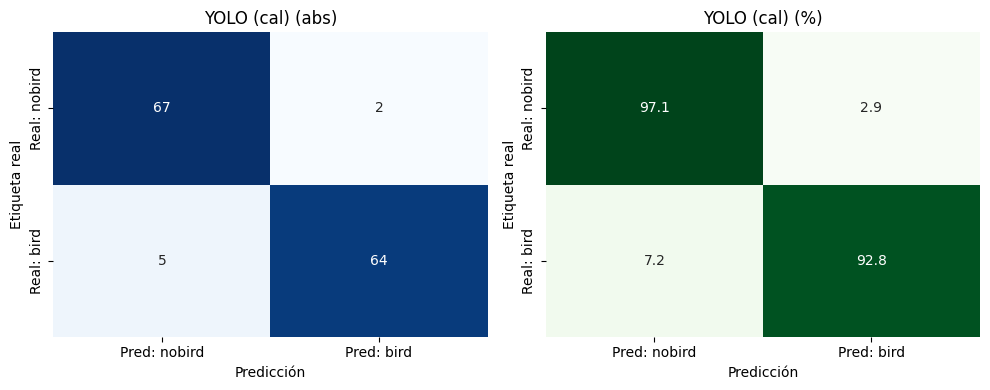

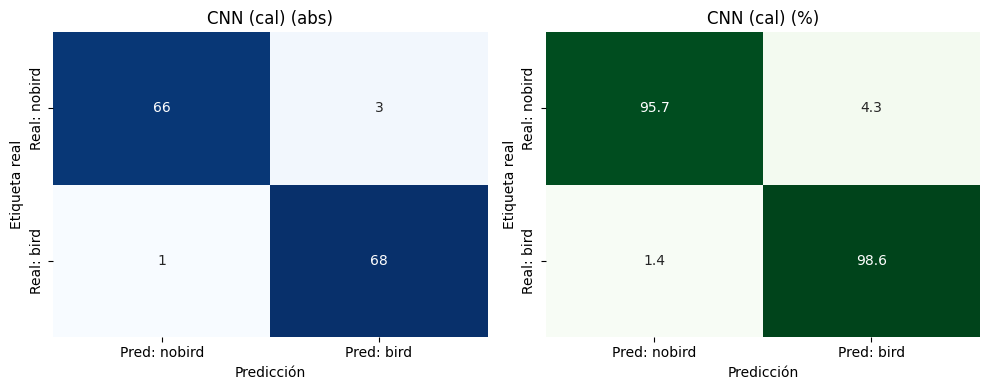

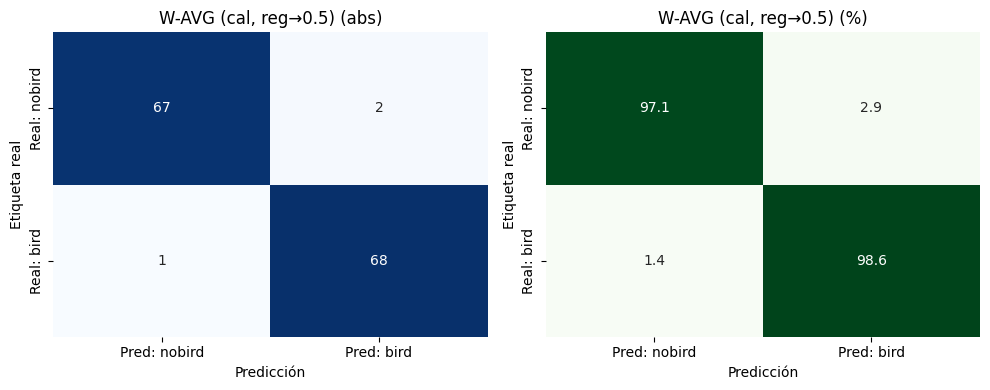

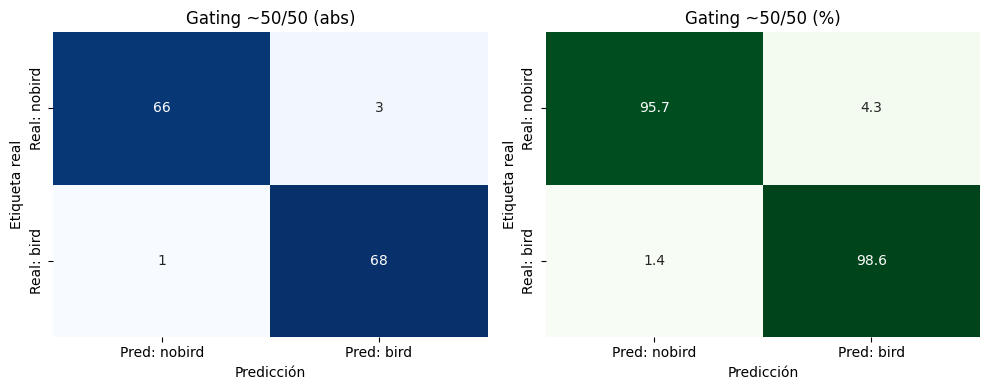

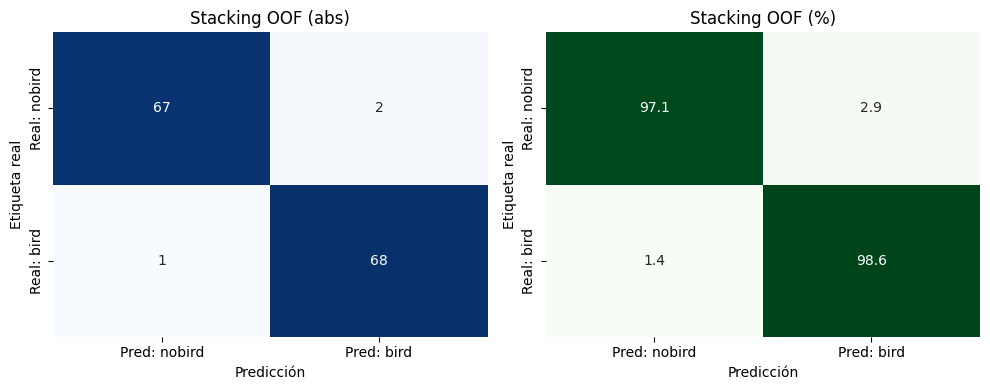

In [6]:
# ==================== ENSAMBLES (W-AVG, GATING, STACKING OOF) ====================

ths = np.linspace(0, 0.995, 200)
# --- W-AVG regularizado hacia 0.5
w_grid = np.linspace(0, 1, 41)
lambda_pull = 0.02
best = {"score": -1e9, "w":None, "th":None, "pred":None}
for w in w_grid:
    s = w*ps_cal + (1-w)*yo_cal
    accs = [np.mean(ys == (s >= t).astype(int)) for t in ths]
    i = int(np.argmax(accs)); acc = accs[i]; th = float(ths[i])
    score = acc - lambda_pull*(w-0.5)**2
    if score > best["score"]:
        best.update({"score":score, "w":w, "th":th, "pred":(s>=th).astype(int)})
acc_w = accuracy_score(ys, best["pred"])
prec_w = precision_score(ys, best["pred"], zero_division=0)
rec_w = recall_score(ys, best["pred"], zero_division=0)
f1_w = f1_score(ys, best["pred"], zero_division=0)
cm_w = confusion_matrix(ys, best["pred"])
print(f"\n[W-AVG reg->0.5] w(CNN)={best['w']:.2f} | ACC={acc_w:.4f} | Prec={prec_w:.4f} | Rec={rec_w:.4f} | F1={f1_w:.4f} | th={best['th']:.3f}")

# --- Gating ~50/50
def gating(ps_c, yo_c, delta, tau):
    mask = (np.abs(ps_c - 0.5) <= delta)
    s_out = ps_c.copy()
    s_out[mask] = np.where(yo_c[mask] >= tau, yo_c[mask], ps_c[mask])
    return s_out, mask.mean()

cands = []
for d in np.linspace(0.02, 0.20, 40):
    s_rule, frac = gating(ps_cal, yo_cal, delta=d, tau=0.5)
    cands.append((d, abs(frac-0.5), s_rule, frac))
delta_star, _, s_rule, frac_star = min(cands, key=lambda x: x[1])
accs = [np.mean(ys == (s_rule >= t).astype(int)) for t in ths]
i = int(np.argmax(accs)); th_rule = float(ths[i])
y_pred_rule = (s_rule >= th_rule).astype(int)
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
acc_r = accuracy_score(ys, y_pred_rule)
prec_r = precision_score(ys, y_pred_rule, zero_division=0)
rec_r = recall_score(ys, y_pred_rule, zero_division=0)
f1_r = f1_score(ys, y_pred_rule, zero_division=0)
cm_r = confusion_matrix(ys, y_pred_rule)
print(f"[Gating ~50/50] delta={delta_star:.3f} (frac_duda≈{frac_star:.2f}) | ACC={acc_r:.4f} | Prec={prec_r:.4f} | Rec={rec_r:.4f} | F1={f1_r:.4f} | th={th_rule:.3f}")

# --- Stacking OOF
X_stack = np.stack([ps_cal, yo_cal, ps_cal*yo_cal], axis=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_s = np.zeros(len(ys))
for tr, te in skf.split(X_stack, ys):
    clf = LogisticRegression(C=3.0, solver="lbfgs", max_iter=2000)
    clf.fit(X_stack[tr], ys[tr])
    oof_s[te] = clf.predict_proba(X_stack[te])[:,1]
th_oof, _ = best_threshold(ys, oof_s)
y_pred_oof = (oof_s >= th_oof).astype(int)
acc_o = accuracy_score(ys, y_pred_oof)
prec_o = precision_score(ys, y_pred_oof, zero_division=0)
rec_o = recall_score(ys, y_pred_oof, zero_division=0)
f1_o = f1_score(ys, y_pred_oof, zero_division=0)
cm_o = confusion_matrix(ys, y_pred_oof)
print(f"[STACK OOF] ACC={acc_o:.4f} | Prec={prec_o:.4f} | Rec={rec_o:.4f} | F1={f1_o:.4f} | th={th_oof:.3f}")

# Matrices
plot_cm(res_yolo_cal["cm"], "YOLO (cal)")
plot_cm(res_cnn_cal["cm"], "CNN (cal)")
plot_cm(cm_w, "W-AVG (cal, reg→0.5)")
plot_cm(cm_r, "Gating ~50/50")
plot_cm(cm_o, "Stacking OOF")


# PRUEBAS DE CONTRIBUCIÓN (Ablation, Correlación, McNemar)

### Pruebas de contribución: ablation, correlación de errores y McNemar

Este bloque valida si los **ensambles** realmente aportan sobre los modelos individuales y evalúa la **diferencia estadística** entre predictores.

---

#### 1) Ablation (mejora vs. modelos base)
- Compara la **accuracy** de cada ensamble (**W-AVG**, **Gating**, **Stack OOF**) contra el **mejor** de los modelos calibrados individuales (CNN_cal, YOLO_cal).
- Respuestas booleanas indican si el ensamble supera al mejor modelo base.

---

#### 2) Correlación de errores (CNN vs YOLO)
- Binariza predicciones de CNN_cal y YOLO_cal con sus **umbrales óptimos**.
- Construye vectores de **error** (1 = clasificación incorrecta).
- Calcula la **correlación de Pearson** entre ambos errores (valores altos ⇒ fallan en ejemplos similares; valores bajos ⇒ errores complementarios y mayor potencial de ensamble).

---

#### 3) Test de McNemar (significancia emparejada)
- Para cada ensamble, compara frente a CNN y YOLO usando **McNemar** con conteos:
  - `b`: casos donde **modelo A** acierta y **modelo B** falla.
  - `c`: casos donde **modelo A** falla y **modelo B** acierta.
- Reporta el **p-value** (exacto).  
  - **p bajo** (p. ej., < 0.05) sugiere **diferencia significativa** en desempeño emparejado.  
  - Muestra resultados para: `W-AVG vs CNN/YOLO`, `Gating vs CNN/YOLO`, `Stack OOF vs CNN/YOLO`.

En conjunto, estas pruebas indican **si** y **cuánto** aporta cada ensamble, si sus errores son **complementarios** y si las mejoras son **estadísticamente significativas**.


In [7]:
# ==================== PRUEBAS DE CONTRIBUCIÓN (Ablation, Correlación, McNemar) ====================

print("\n--- ABLATIONS ---")
print("W-AVG > max(CNN_cal, YOLO_cal)?", (accuracy_score(ys, (best['pred'])) > max(res_cnn_cal["acc"], res_yolo_cal["acc"])))
print("Gating> max(CNN_cal, YOLO_cal)?", (accuracy_score(ys, (y_pred_rule)) > max(res_cnn_cal["acc"], res_yolo_cal["acc"])))
print("Stack > max(CNN_cal, YOLO_cal)?", (accuracy_score(ys, (y_pred_oof)) > max(res_cnn_cal["acc"], res_yolo_cal["acc"])))

yhat_cnn = (res_cnn_cal["score"]  >= res_cnn_cal["th"]).astype(int)
yhat_yolo = (res_yolo_cal["score"] >= res_yolo_cal["th"]).astype(int)
err_cnn = (yhat_cnn != ys).astype(int)
err_yolo= (yhat_yolo != ys).astype(int)
corr = np.corrcoef(err_cnn, err_yolo)[0,1]
print(f"Correlación de errores (CNN vs YOLO): {corr:.3f}")

def mcnemar_test(y1, y2, y_true):
    ok1 = (y1 == y_true); ok2 = (y2 == y_true)
    b = int(np.sum(ok1 & ~ok2)); c = int(np.sum(~ok1 & ok2))
    res = mcnemar([[0, b],[c, 0]], exact=True)
    return b, c, res.pvalue

from sklearn.metrics import accuracy_score
y_pred_w = best['pred']
y_pred_r = y_pred_rule
y_pred_o = y_pred_oof

print("\n--- McNemar (p-values; bajo = diferencia significativa) ---")
for name, yhat in [("W-AVG", y_pred_w), ("Gating", y_pred_r), ("Stack OOF", y_pred_o)]:
    b, c, p = mcnemar_test(yhat_cnn, yhat, ys)
    print(f"{name} vs CNN: b={b}, c={c}, p={p:.4g}")
for name, yhat in [("W-AVG", y_pred_w), ("Gating", y_pred_r), ("Stack OOF", y_pred_o)]:
    b, c, p = mcnemar_test(yhat_yolo, yhat, ys)
    print(f"{name} vs YOLO: b={b}, c={c}, p={p:.4g}")



--- ABLATIONS ---
W-AVG > max(CNN_cal, YOLO_cal)? True
Gating> max(CNN_cal, YOLO_cal)? False
Stack > max(CNN_cal, YOLO_cal)? True
Correlación de errores (CNN vs YOLO): 0.354

--- McNemar (p-values; bajo = diferencia significativa) ---
W-AVG vs CNN: b=0, c=1, p=1
Gating vs CNN: b=0, c=0, p=1
Stack OOF vs CNN: b=0, c=1, p=1
W-AVG vs YOLO: b=1, c=5, p=0.2188
Gating vs YOLO: b=2, c=5, p=0.4531
Stack OOF vs YOLO: b=1, c=5, p=0.2188


# VERIFICACIÓN DE CONSISTENCIA (métricas vs matrices)

### Verificación de consistencia: métricas vs. matrices de confusión

Este bloque comprueba que las **métricas calculadas** (accuracy, precision, recall, F1) coincidan con las mismas métricas **reconstruidas desde la matriz de confusión** para cada modelo/ensamble.

---

#### Funciones clave
- `from_cm_metrics(cm)`: calcula ACC/Prec/Rec/F1 a partir de `cm = [[TN, FP],[FN, TP]]`.
- `compare_block(name, y_true, score=None, th=None, pred=None, cm=None)`:
  1) Reconstruye `pred` desde `score` y `th` si no se proporcionan.  
  2) Calcula/usa la matriz de confusión `cm`.  
  3) Obtiene métricas por dos vías:  
     - Directamente desde `pred` (scikit-learn).  
     - Derivadas de la `cm` (con `from_cm_metrics`).  
  4) Imprime las **diferencias** (deberían ser ~0).  
  5) Devuelve `True/False` según coherencia numérica.

---

#### Etiquetas canónicas
- `y_true_can`: se reconstruye desde `val_ds` garantizando la convención **1 = bird** y mismo orden que validación.

---

#### Verificaciones realizadas
Se llama `compare_block` para:
- **YOLO (calibrado)**: usa `res_yolo_cal["score"]`, `res_yolo_cal["th"]`, `res_yolo_cal["cm"]`.  
- **CNN (calibrada)**: usa `res_cnn_cal["score"]`, `res_cnn_cal["th"]`, `res_cnn_cal["cm"]`.  
- **W-AVG**: mezcla `ps_cal` y `yo_cal` con el mejor peso `best["w"]` y umbral `best["th"]`, compara con `cm_w`.  
- **Gating ~50/50**: evalúa `y_pred_rule` y `cm_r`.  
- **Stacking OOF**: evalúa `y_pred_oof` y `cm_o` (opcionalmente `oof_s` como `score`).

---

#### Salida final
Imprime un **resumen** tipo `OK/BAD` por método.  
Si todo está **OK**, las métricas reportadas en el notebook son **consistentes** con sus matrices de confusión, lo que valida el pipeline de evaluación.




In [8]:
# ==================== VERIFICACIÓN DE CONSISTENCIA (métricas vs matrices) ====================

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def from_cm_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    acc = (tn+tp) / (tn+fp+fn+tp) if (tn+fp+fn+tp)>0 else 0.0
    prec = (tp/(tp+fp)) if (tp+fp)>0 else 0.0
    rec = (tp/(tp+fn)) if (tp+fn)>0 else 0.0
    f1 = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0.0
    return acc, prec, rec, f1

def compare_block(name, y_true, score=None, th=None, pred=None, cm=None):
    print(f"\n=== {name} ===")
    # 1) Reconstruye predicciones si hace falta
    if pred is None:
        assert score is not None and th is not None, f"{name}: falta score o th para recomputar pred"
        pred = (score >= th).astype(int)
    pred = pred.astype(int)

    # 2) Matriz
    if cm is None:
        cm = confusion_matrix(y_true, pred)
    print("CM [[TN FP],[FN TP]]:", cm.tolist())

    # 3) Métricas desde pred
    acc_p = accuracy_score(y_true, pred)
    prec_p = precision_score(y_true, pred, zero_division=0)
    rec_p = recall_score(y_true, pred, zero_division=0)
    f1_p = f1_score(y_true, pred, zero_division=0)

    # 4) Métricas desde la CM
    acc_c, prec_c, rec_c, f1_c = from_cm_metrics(cm)

    # 5) Deltas (deberían ser ~0)
    print(f"Pred -> ACC={acc_p:.6f} | Prec={prec_p:.6f} | Rec={rec_p:.6f} | F1={f1_p:.6f}")
    print(f"CM -> ACC={acc_c:.6f} | Prec={prec_c:.6f} | Rec={rec_c:.6f} | F1={f1_c:.6f}")
    print(f"DIF -> ACC={acc_p-acc_c:+.6e} | Prec={prec_p-prec_c:+.6e} | Rec={rec_p-rec_c:+.6e} | F1={f1_p-f1_c:+.6e}")

    # 6) Chequeo de coherencia
    ok = all(abs(d) < 1e-9 for d in [acc_p-acc_c, prec_p-prec_c, rec_p-rec_c, f1_p-f1_c])
    print("CONSISTENTE:", "YES" if ok else "NO")
    return ok

# --- y_true asegura 1=bird, 0=nobird
y_true_can = np.array([1 if cls == bird_idx else 0 for _, cls in val_ds.samples], dtype=int)

# --- YOLO (calibrado)
ok_yolo = compare_block(
    "YOLO (cal)",
    y_true_can,
    score = res_yolo_cal["score"],
    th = res_yolo_cal["th"],
    pred = (res_yolo_cal["score"] >= res_yolo_cal["th"]).astype(int),
    cm = res_yolo_cal["cm"]
)

# --- CNN (calibrada)
ok_cnn = compare_block(
    "CNN (cal)",
    y_true_can,
    score = res_cnn_cal["score"],
    th = res_cnn_cal["th"],
    pred = (res_cnn_cal["score"] >= res_cnn_cal["th"]).astype(int),
    cm = res_cnn_cal["cm"]
)

# --- W-AVG
s_w = best["w"]*res_cnn_cal["score"] + (1-best["w"])*res_yolo_cal["score"]
ok_w = compare_block(
    "W-AVG (cal, reg→0.5)",
    y_true_can,
    score = s_w,
    th = best["th"],
    pred = best["pred"],
    cm = cm_w
)

# --- Gating (~50/50)
ok_r = compare_block(
    "Gating ~50/50",
    y_true_can,
    score = None,
    th = None,
    pred = y_pred_rule,
    cm = cm_r
)

# --- Stacking OOF
ok_o = compare_block(
    "Stacking OOF",
    y_true_can,
    score = oof_s,
    th = None,
    pred = y_pred_oof,
    cm = cm_o
)

print("\nRESUMEN ->",
      f"YOLO:{'OK' if ok_yolo else 'BAD'} |",
      f"CNN:{'OK' if ok_cnn else 'BAD'} |",
      f"W-AVG:{'OK' if ok_w else 'BAD'} |",
      f"Gating:{'OK' if ok_r else 'BAD'} |",
      f"Stacking:{'OK' if ok_o else 'BAD'}")



=== YOLO (cal) ===
CM [[TN FP],[FN TP]]: [[67, 2], [5, 64]]
Pred -> ACC=0.949275 | Prec=0.969697 | Rec=0.927536 | F1=0.948148
CM -> ACC=0.949275 | Prec=0.969697 | Rec=0.927536 | F1=0.948148
DIF -> ACC=+0.000000e+00 | Prec=+0.000000e+00 | Rec=+0.000000e+00 | F1=+1.110223e-16
CONSISTENTE: YES

=== CNN (cal) ===
CM [[TN FP],[FN TP]]: [[66, 3], [1, 68]]
Pred -> ACC=0.971014 | Prec=0.957746 | Rec=0.985507 | F1=0.971429
CM -> ACC=0.971014 | Prec=0.957746 | Rec=0.985507 | F1=0.971429
DIF -> ACC=+0.000000e+00 | Prec=+0.000000e+00 | Rec=+0.000000e+00 | F1=+0.000000e+00
CONSISTENTE: YES

=== W-AVG (cal, reg→0.5) ===
CM [[TN FP],[FN TP]]: [[67, 2], [1, 68]]
Pred -> ACC=0.978261 | Prec=0.971429 | Rec=0.985507 | F1=0.978417
CM -> ACC=0.978261 | Prec=0.971429 | Rec=0.985507 | F1=0.978417
DIF -> ACC=+0.000000e+00 | Prec=+0.000000e+00 | Rec=+0.000000e+00 | F1=+0.000000e+00
CONSISTENTE: YES

=== Gating ~50/50 ===
CM [[TN FP],[FN TP]]: [[66, 3], [1, 68]]
Pred -> ACC=0.971014 | Prec=0.957746 | Rec=0.985

# VERIFICACIÓN DE CONSISTENCIA (métricas vs matrices)


---


### Mosaico comparativo: visualización por contexto (natural vs. no natural)

Este bloque crea **grillas de imágenes** para comparar visualmente ejemplos de `bird` y `nobird` en contextos **naturales** vs **no naturales** (si existen subcarpetas de contexto).

---

#### Configuración
- Directorio base: `/content/drive/MyDrive/openimages_v7/dataset_cls`.
- `splits = ["train","val"]` y clases `bird`/`nobird`.
- `n_per_group`: cuántas imágenes por fila (por grupo).
- Conjunto de nombres válidos para subcarpetas de contexto:
  - Naturales: `{natural, naturales, nature}`
  - No naturales: `{non_natural, no_natural, urbano, urban, artificial}`

---

#### Helpers
- `find_context_dirs(base_dir, class_name)`: busca subcarpetas de contexto (natural/no natural) en `train` y `val`.
- `list_images_from_dirs(dirs)`: lista imágenes en directorios dados.
- `list_images_simple(base_dir, class_name)`: lista imágenes de una clase sin suponer subcarpetas.
- `draw_grid(img_paths, n_rows, n_cols, title, save_path, row_labels)`: dibuja un **grid compacto** (oculta ejes, etiqueta filas opcionalmente) y guarda PNG.
- `sample_or_all(img_list, k)`: devuelve muestra aleatoria de tamaño `k` o todo si hay menos.

---

#### Sección BIRD
1. Busca subcarpetas de contexto; si no existen, toma una **muestra aleatoria** y la divide en dos grupos “aproximados”.
2. Dibuja un grid de 2 filas × `n_per_group` columnas:
   - Fila 1: **NATURAL**
   - Fila 2: **NO NATURAL**
3. Guarda como `preview_bird_natural_vs_non_natural.png`.

---

#### Sección NOBIRD
- Si **no** hay subcarpetas de contexto:
  - Muestra general de `nobird` en un panel de 2 filas para diversidad; guarda `preview_nobird_general.png`.
- Si **sí** hay subcarpetas:
  - Mosaico **NOBIRD: Natural vs No natural** análogo al de `bird`; guarda `preview_nobird_natural_vs_non_natural.png`.

---

#### Notas
- Reproducibilidad controlada con `random_seed`.
- Soporta múltiples extensiones (`.jpg`, `.png`, `.webp`, etc.).
- Maneja errores de lectura de imágenes mostrando un texto de respaldo en la celda correspondiente.


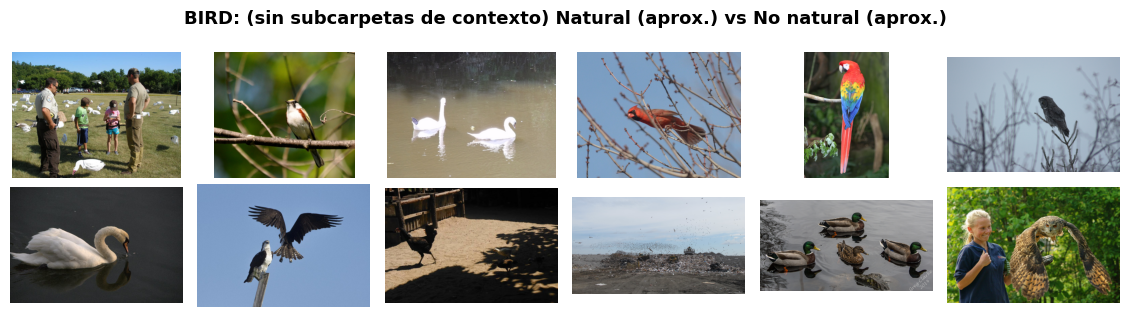

[OK] Figura guardada en: /content/drive/MyDrive/openimages_v7/dataset_cls/preview_bird_natural_vs_non_natural.png


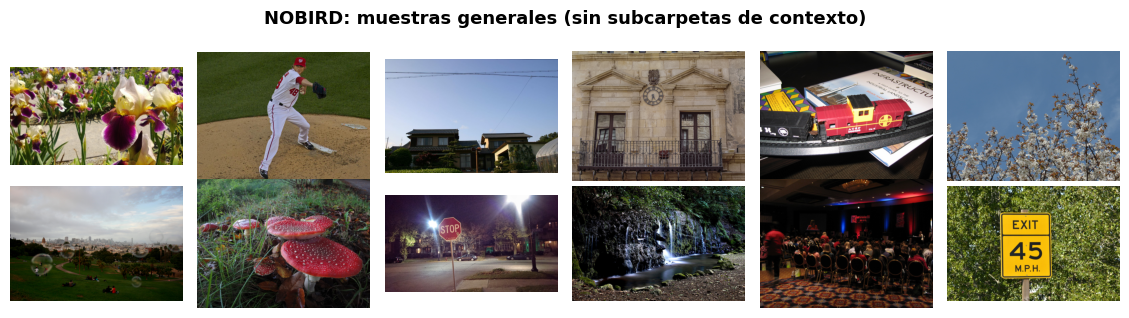

[OK] Figura guardada en: /content/drive/MyDrive/openimages_v7/dataset_cls/preview_nobird_general.png


In [9]:
# ==================== MOSAICO COMPARATIVO ====================

import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# ---------- Config ----------
root = Path("/content/drive/MyDrive/openimages_v7/dataset_cls")
splits = ["train", "val"]
bird_label = "bird"
nobird_label = "nobird"
n_per_group = 6          # imágenes por grupo (por columna)
random_seed = 42         # fija reproducibilidad

# Nombres posibles de subcarpetas de contexto
NAT_NAMES = {"natural", "naturales", "nature"}
NONNAT_NAMES = {"non_natural", "no_natural", "urbano", "urban", "artificial"}

random.seed(random_seed)

# ---------- Helpers ----------
def find_context_dirs(base_dir: Path, class_name: str):
    """
    Busca subcarpetas de contexto dentro de base_dir/class_name para los splits indicados.
    Devuelve dos listas de rutas de directorio: (naturales[], no_naturales[]).
    """
    nat_dirs = []
    nonnat_dirs = []
    for sp in splits:
        cdir = base_dir / sp / class_name
        if not cdir.exists():
            continue
        # Buscar subcarpetas
        for d in cdir.iterdir():
            if not d.is_dir():
                continue
            name = d.name.lower()
            if name in NAT_NAMES:
                nat_dirs.append(d)
            if name in NONNAT_NAMES:
                nonnat_dirs.append(d)
    return nat_dirs, nonnat_dirs

def list_images_from_dirs(dirs, exts={".jpg",".jpeg",".png",".bmp",".tiff",".webp"}):
    imgs = []
    for d in dirs:
        imgs.extend([p for p in d.rglob("*") if p.suffix.lower() in exts])
    return imgs

def list_images_simple(base_dir: Path, class_name: str):
    imgs = []
    for sp in splits:
        imgs.extend((base_dir/sp/class_name).rglob("*.jpg"))
        imgs.extend((base_dir/sp/class_name).rglob("*.jpeg"))
        imgs.extend((base_dir/sp/class_name).rglob("*.png"))
        imgs.extend((base_dir/sp/class_name).rglob("*.bmp"))
        imgs.extend((base_dir/sp/class_name).rglob("*.tiff"))
        imgs.extend((base_dir/sp/class_name).rglob("*.webp"))
    return imgs

def draw_grid(img_paths, n_rows, n_cols, title, save_path=None, row_labels=None):
    """Dibuja un grid compacto. row_labels: lista de etiquetas por fila (opcional)."""
    if len(img_paths) == 0:
        print(f"[WARN] Sin imágenes para: {title}")
        return
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.9*n_cols, 1.6*n_rows))
    # Asegura que axes sea 2D
    if n_rows == 1:
        axes = [axes]
    for i in range(n_rows):
        for j in range(n_cols):
            idx = i*n_cols + j
            ax = axes[i][j] if n_rows > 1 else axes[j]
            ax.axis("off")
            if idx < len(img_paths):
                try:
                    with Image.open(img_paths[idx]) as im:
                        ax.imshow(im)
                except Exception as e:
                    ax.text(0.5, 0.5, "Error", ha="center", va="center")
            if row_labels and j == 0:
                ax.set_ylabel(row_labels[i], fontsize=11, weight="bold")
    plt.suptitle(title, fontsize=13, weight="bold")
    plt.tight_layout()
    plt.show()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"[OK] Figura guardada en: {save_path}")

def sample_or_all(img_list, k):
    if len(img_list) == 0:
        return []
    if len(img_list) <= k:
        return img_list
    return random.sample(img_list, k)

# ---------- BIRD: Natural vs No Natural ----------
bird_nat_dirs, bird_nonnat_dirs = find_context_dirs(root, bird_label)

bird_nat_imgs = list_images_from_dirs(bird_nat_dirs)
bird_nonnat_imgs = list_images_from_dirs(bird_nonnat_dirs)

# Fallback si no hay subcarpetas de contexto: toma aleatorias de BIRD y divide mitad/mitad
if len(bird_nat_imgs) == 0 and len(bird_nonnat_imgs) == 0:
    bird_all = list_images_simple(root, bird_label)
    random.shuffle(bird_all)
    half = max(1, min(len(bird_all)//2, n_per_group))
    bird_nat_imgs = bird_all[:half]
    bird_nonnat_imgs = bird_all[half:half+n_per_group]
    title_bird = "BIRD: (sin subcarpetas de contexto) Natural (aprox.) vs No natural (aprox.)"
else:
    title_bird = "BIRD: Natural vs No natural"

bird_nat_sample = sample_or_all(bird_nat_imgs, n_per_group)
bird_nonnat_sample = sample_or_all(bird_nonnat_imgs, n_per_group)

draw_grid(
    img_paths = bird_nat_sample + bird_nonnat_sample,
    n_rows = 2,
    n_cols = n_per_group,
    title = title_bird,
    save_path = root / "preview_bird_natural_vs_non_natural.png",
    row_labels = ["NATURAL", "NO NATURAL"]
)

# ---------- NOBIRD: panel separado ----------
nobird_nat_dirs, nobird_nonnat_dirs = find_context_dirs(root, nobird_label)
nobird_nat_imgs = list_images_from_dirs(nobird_nat_dirs)
nobird_nonnat_imgs = list_images_from_dirs(nobird_nonnat_dirs)

if len(nobird_nat_imgs) == 0 and len(nobird_nonnat_imgs) == 0:
    # Sin subcarpetas de contexto: panel único con NOBIRD general (dos filas para variedad)
    nobird_all = list_images_simple(root, nobird_label)
    nobird_sample = sample_or_all(nobird_all, 2*n_per_group)
    # Rellena si hay menos de lo pedido
    if len(nobird_sample) < 2*n_per_group:
        nobird_sample = nobird_sample + nobird_sample[:max(0, 2*n_per_group - len(nobird_sample))]
    draw_grid(
        img_paths = nobird_sample,
        n_rows = 2,
        n_cols = n_per_group,
        title = "NOBIRD: muestras generales (sin subcarpetas de contexto)",
        save_path = root / "preview_nobird_general.png",
        row_labels = ["Fila 1", "Fila 2"]
    )
else:
    # Con subcarpetas: mostrar NOBIRD natural vs no natural
    nobird_nat_sample = sample_or_all(nobird_nat_imgs, n_per_group)
    nobird_nonnat_sample = sample_or_all(nobird_nonnat_imgs, n_per_group)
    draw_grid(
        img_paths = nobird_nat_sample + nobird_nonnat_sample,
        n_rows = 2,
        n_cols = n_per_group,
        title = "NOBIRD: Natural vs No natural",
        save_path = root / "preview_nobird_natural_vs_non_natural.png",
        row_labels = ["NATURAL", "NO NATURAL"]
    )


# GATING BIDIRECCIONAL

#### Gating bidireccional: regla y búsqueda rápida de hiperparámetros

Este bloque aplica y luego optimiza una regla **gating bidireccional** que ajusta las probabilidades de la CNN (`ps_cal`) usando a YOLO (`yo_cal`) solo en una **zona de duda** alrededor de 0.5.

---

#### 1) Regla básica (`gating_bidir`)
- **Zona de duda**: `|ps_c - 0.5| ≤ delta`.
- Si `yo_c ≥ tau_hi` (YOLO “alto”), **empuja** la probabilidad hacia *bird* (≥ 0.60).
- Si `yo_c ≤ tau_lo` (YOLO “bajo”), **empuja** hacia *nobird* (≤ 0.40).
- Fuera de la zona de duda, conserva `ps_c`.

Se barre un umbral de decisión y se reportan **ACC/Prec/Rec/F1** y la **matriz de confusión** para evaluar la regla.

---

#### 2) Búsqueda en rejilla (mini-grid)
Se redefine `gating_bidir` con empujes configurables (`hi_push`, `lo_push`) y se exploran:
- `delta ∈ [0.05, 0.25]` (tamaño de la zona de duda),
- `tau_hi ∈ [0.55, 0.85]` (cuán alto debe ser YOLO para favorecer *bird*),
- `tau_lo ∈ [0.15, 0.45]` (cuán bajo debe ser YOLO para favorecer *nobird*).

Para cada tripleta `(delta, tau_hi, tau_lo)`:
1. Aplica la regla y obtiene el vector ajustado y la **fracción en duda** (`frac`).
2. Barre umbrales y elige el que **maximiza accuracy**.
3. Si mejora el mejor resultado, guarda `ACC`, `th`, `pred`, `cm`, la configuración y `frac`.

La salida final imprime:
- Mejor **ACC** y **umbral**,
- La configuración óptima `(delta, tau_hi, tau_lo)`,
- `frac_duda` (qué porcentaje fue intervenido),
- **Matriz de confusión** del mejor caso.

---

#### Notas
- `delta` más grande ⇒ más intervención (más ejemplos en la zona de duda).
- `tau_hi`/`tau_lo` controlan la **confianza mínima** de YOLO para influir.
- `hi_push` y `lo_push` regulan la **intensidad** del ajuste (p. ej., 0.65/0.35).



[Gating bidir] ACC=0.9710 | Prec=0.9577 | Rec=0.9855 | F1=0.9714 | th=0.255
CM [[TN FP],[FN TP]]:
 [[66  3]
 [ 1 68]]
[Gating-bidir GRID] ACC=0.9783 | th=0.350 | delta=0.250 tau_hi=0.55 tau_lo=0.15 | frac_duda≈0.12
CM [[TN FP],[FN TP]]:
 [[67  2]
 [ 1 68]]


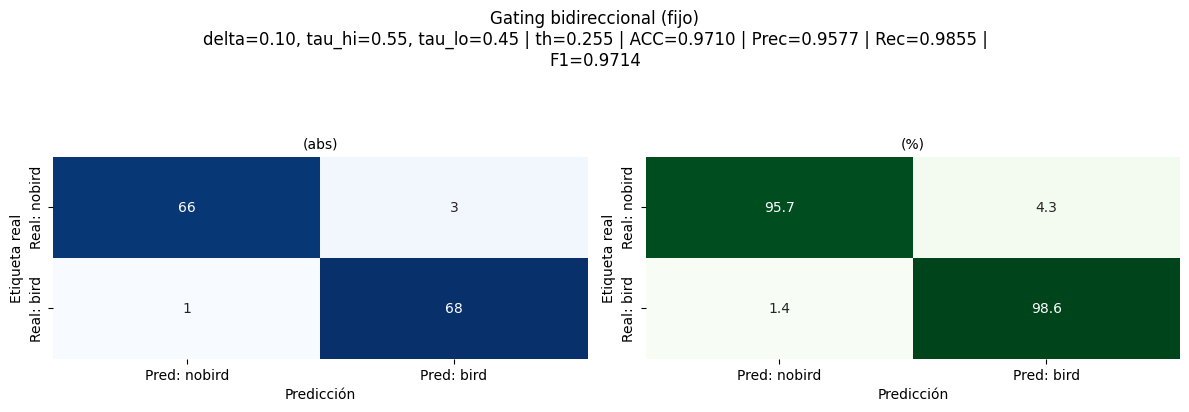

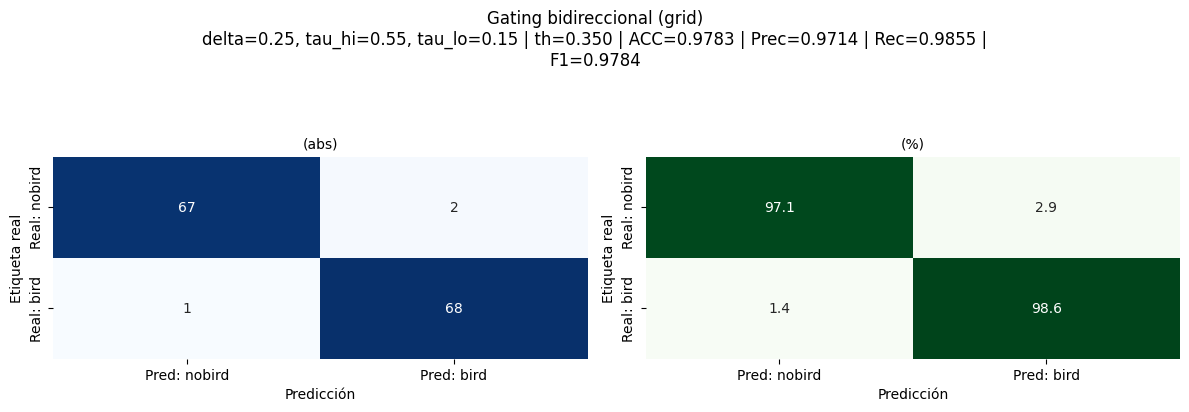

In [10]:
# ==================== GATING BIDIRECCIONAL ====================

def gating_bidir(ps_c, yo_c, delta=0.10, tau_hi=0.55, tau_lo=0.45):
    mask = (np.abs(ps_c - 0.5) <= delta)
    s_out = ps_c.copy()
    s_out[mask & (yo_c >= tau_hi)] = np.maximum(s_out[mask & (yo_c >= tau_hi)], 0.60)
    s_out[mask & (yo_c <= tau_lo)] = np.minimum(s_out[mask & (yo_c <= tau_lo)], 0.40)
    return s_out

s_rule2 = gating_bidir(ps_cal, yo_cal, delta=0.10, tau_hi=0.55, tau_lo=0.45)
ths = np.linspace(0, 0.995, 200)
accs = [np.mean(ys == (s_rule2 >= t).astype(int)) for t in ths]
i = int(np.argmax(accs))
th2 = float(ths[i])
y_pred2 = (s_rule2 >= th2).astype(int)

acc2 = accuracy_score(ys, y_pred2)
prec2 = precision_score(ys, y_pred2, zero_division=0)
rec2 = recall_score(ys, y_pred2, zero_division=0)
f12 = f1_score(ys, y_pred2, zero_division=0)
cm2 = confusion_matrix(ys, y_pred2)

print(f"[Gating bidir] ACC={acc2:.4f} | Prec={prec2:.4f} | Rec={rec2:.4f} | F1={f12:.4f} | th={th2:.3f}")
print("CM [[TN FP],[FN TP]]:\n", cm2)

def gating_bidir(ps_c, yo_c, delta=0.10, tau_hi=0.55, tau_lo=0.45, hi_push=0.65, lo_push=0.35):
    mask = (np.abs(ps_c - 0.5) <= delta)
    s_out = ps_c.copy()
    s_out[mask & (yo_c >= tau_hi)] = np.maximum(s_out[mask & (yo_c >= tau_hi)], hi_push)
    s_out[mask & (yo_c <= tau_lo)] = np.minimum(s_out[mask & (yo_c <= tau_lo)], lo_push)
    return s_out, mask.mean()

ths = np.linspace(0, 0.995, 200)
best = {"acc": -1, "cfg": None, "th": None, "pred": None, "cm": None, "frac": None}
for delta in np.linspace(0.05, 0.25, 9):
    for tau_hi in np.linspace(0.55, 0.85, 7):
        for tau_lo in np.linspace(0.15, 0.45, 7):
            s_rule, frac = gating_bidir(
                ps_cal, yo_cal, delta=delta, tau_hi=tau_hi, tau_lo=tau_lo,
                hi_push=0.65, lo_push=0.35
            )
            accs = [np.mean(ys == (s_rule >= t).astype(int)) for t in ths]
            i = int(np.argmax(accs))
            acc, th = float(accs[i]), float(ths[i])
            if acc > best["acc"]:
                y_pred = (s_rule >= th).astype(int)
                best.update({
                    "acc": acc,
                    "cfg": (delta, tau_hi, tau_lo),
                    "th": th,
                    "pred": y_pred,
                    "cm": confusion_matrix(ys, y_pred),
                    "frac": frac
                })

print(
    f"[Gating-bidir GRID] ACC={best['acc']:.4f} | th={best['th']:.3f} | "
    f"delta={best['cfg'][0]:.3f} tau_hi={best['cfg'][1]:.2f} tau_lo={best['cfg'][2]:.2f} | "
    f"frac_duda≈{best['frac']:.2f}"
)
print("CM [[TN FP],[FN TP]]:\n", best["cm"])

import re
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def _ascii_only(s: str) -> str:
    return re.sub(r"[^\x00-\x7F]+", " ", s)

def plot_cm_pretty(cm, main_title, meta_title, cmap_abs="Blues", cmap_pct="Greens"):
    cm = np.asarray(cm)
    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100.0

    main_title = _ascii_only(main_title).strip()
    meta_title = _ascii_only(meta_title).strip()
    meta_title_wrapped = "\n".join(textwrap.wrap(meta_title, width=90))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4.2))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap=cmap_abs, cbar=False,
        xticklabels=['Pred: nobird', 'Pred: bird'],
        yticklabels=['Real: nobird', 'Real: bird'],
        ax=ax[0]
    )
    ax[0].set_title("(abs)", fontsize=10, pad=6)
    ax[0].set_xlabel("Predicci\u00f3n"); ax[0].set_ylabel("Etiqueta real")

    sns.heatmap(
        cm_pct, annot=True, fmt='.1f', cmap=cmap_pct, cbar=False,
        xticklabels=['Pred: nobird', 'Pred: bird'],
        yticklabels=['Real: nobird', 'Real: bird'],
        ax=ax[1]
    )
    ax[1].set_title("(%)", fontsize=10, pad=6)
    ax[1].set_xlabel("Predicci\u00f3n"); ax[1].set_ylabel("Etiqueta real")

    fig.suptitle(f"{main_title}\n{meta_title_wrapped}", fontsize=12, y=0.97)
    fig.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()

main_fixed = "Gating bidireccional (fijo)"
meta_fixed = (
    f"delta=0.10, tau_hi=0.55, tau_lo=0.45 | th={th2:.3f} | "
    f"ACC={acc2:.4f} | Prec={prec2:.4f} | Rec={rec2:.4f} | F1={f12:.4f}"
)
plot_cm_pretty(cm2, main_fixed, meta_fixed)

delta_b, tauhi_b, taulo_b = best["cfg"]
prec_b = precision_score(ys, best["pred"], zero_division=0)
rec_b  = recall_score(ys, best["pred"], zero_division=0)
f1_b   = f1_score(ys, best["pred"], zero_division=0)

main_grid = "Gating bidireccional (grid)"
meta_grid = (
    f"delta={delta_b:.2f}, tau_hi={tauhi_b:.2f}, tau_lo={taulo_b:.2f} | "
    f"th={best['th']:.3f} | ACC={best['acc']:.4f} | Prec={prec_b:.4f} | Rec={rec_b:.4f} | F1={f1_b:.4f}"
)
plot_cm_pretty(best["cm"], main_grid, meta_grid)


# Implementación de curvas ROC y de calibración

Para complementar el análisis cuantitativo de desempeño, se implementaron gráficos que visualizan el equilibrio entre **sensibilidad** y **especificidad**, así como la **calidad de la calibración probabilística**. En particular:

- **Curvas ROC (Receiver Operating Characteristic)** para: **YOLO calibrado**, **CNN calibrada** y el **Ensamble con Gating Bidireccional**.
- **Gráfico de calibración (Reliability Curve)** únicamente para el **Ensamble con Gating Bidireccional**, que combina **calibración isotónica** y **ajuste adaptativo** de probabilidades.

El código (más abajo) utiliza `scikit-learn`:
- `roc_curve` y `auc` para obtener **TPR** (*True Positive Rate / Recall*) y **FPR** (*False Positive Rate = 1 - Specificity*) en múltiples umbrales, y el **AUC** como métrica sintética de rendimiento.
- `calibration_curve` y `brier_score_loss` para evaluar la **calibración** del ensamble comparando la **probabilidad media predicha** con la **frecuencia observada** por bins, y el **Brier score** como error cuadrático medio de probabilidad.

**¿Qué validan estas gráficas?**

1) **Capacidad discriminativa (ROC/AUC):** qué tan bien separan las clases *bird* vs. *nobird* bajo distintos umbrales.  
2) **Confiabilidad probabilística (Calibración/Brier):** cuán coherentes son las probabilidades emitidas con las frecuencias empíricas.

Estas dos miradas son complementarias: la **ROC** evidencia la mejora discriminativa del **ensamble** frente a sus componentes individuales, mientras que la **calibración** muestra que la combinación de **Isotonic Regression** + **Gating Bidireccional** produce probabilidades **bien calibradas**, aumentando la **interpretabilidad** y la **robustez** frente a cambios de umbral.

---

### Figuras sugeridas (una vez generadas por el código)

```markdown
![Curvas ROC comparativas (YOLO, CNN, Gating)](figs/roc_yolo_cnn_gating.png)

![Gráfico de calibración y Brier score (Gating bidireccional)](figs/calibracion_gating.png)


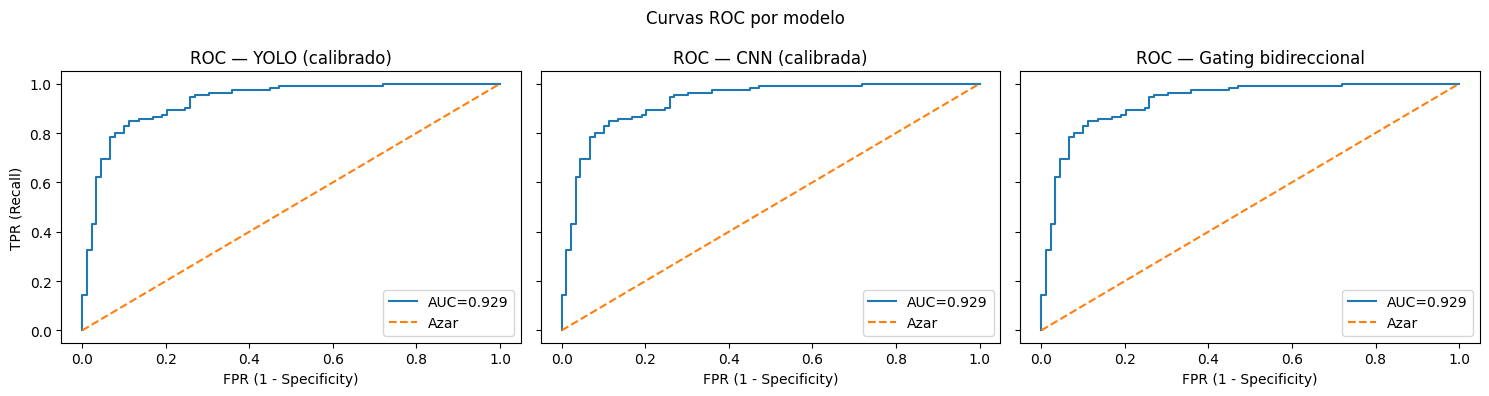

Figura guardada en: figs/roc_grid_1x3.png
AUC -> YOLO: 0.9285 | CNN: 0.9285 | Gating: 0.9285


In [18]:
# ============================================================
# Curvas ROC en grilla 1x3: YOLO, CNN y Gating bidireccional
# Guarda la figura en figs/roc_grid_1x3.png
# ============================================================
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# (Opcional) si no están definidas, crea datos demo para probar:
if not all(k in globals() for k in ("y_true","p_yolo_cal","p_cnn_cal","p_gate")):
    rng = np.random.default_rng(0)
    n = 200
    y_true = rng.integers(0, 2, size=n)
    z = (y_true*2-1) + rng.normal(0, 0.9, size=n)
    p_yolo_cal = 1/(1+np.exp(-z*0.9))
    p_cnn_cal  = 1/(1+np.exp(-z*1.2))
    p_gate     = 1/(1+np.exp(-z*1.3))

os.makedirs("figs", exist_ok=True)

def roc_points(y, p):
    fpr, tpr, _ = roc_curve(y, p)
    return fpr, tpr, auc(fpr, tpr)

# Cálculo de puntos y AUC
fpr_y, tpr_y, auc_y = roc_points(y_true, p_yolo_cal)
fpr_c, tpr_c, auc_c = roc_points(y_true, p_cnn_cal)
fpr_g, tpr_g, auc_g = roc_points(y_true, p_gate)

# Grilla 1x3
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

# Panel YOLO
axs[0].plot(fpr_y, tpr_y, label=f"AUC={auc_y:.3f}")
axs[0].plot([0, 1], [0, 1], linestyle="--", label="Azar")
axs[0].set_title("ROC — YOLO (calibrado)")
axs[0].set_xlabel("FPR (1 - Specificity)")
axs[0].set_ylabel("TPR (Recall)")
axs[0].legend(loc="lower right")

# Panel CNN
axs[1].plot(fpr_c, tpr_c, label=f"AUC={auc_c:.3f}")
axs[1].plot([0, 1], [0, 1], linestyle="--", label="Azar")
axs[1].set_title("ROC — CNN (calibrada)")
axs[1].set_xlabel("FPR (1 - Specificity)")
axs[1].legend(loc="lower right")

# Panel Gating
axs[2].plot(fpr_g, tpr_g, label=f"AUC={auc_g:.3f}")
axs[2].plot([0, 1], [0, 1], linestyle="--", label="Azar")
axs[2].set_title("ROC — Gating bidireccional")
axs[2].set_xlabel("FPR (1 - Specificity)")
axs[2].legend(loc="lower right")

fig.suptitle("Curvas ROC por modelo")
fig.tight_layout()
outpath = "figs/roc_grid_1x3.png"
plt.savefig(outpath, dpi=300)
plt.show()

print(f"Figura guardada en: {outpath}")
print(f"AUC -> YOLO: {auc_y:.4f} | CNN: {auc_c:.4f} | Gating: {auc_g:.4f}")


# EJEMPLO DE EJECUCIÓN


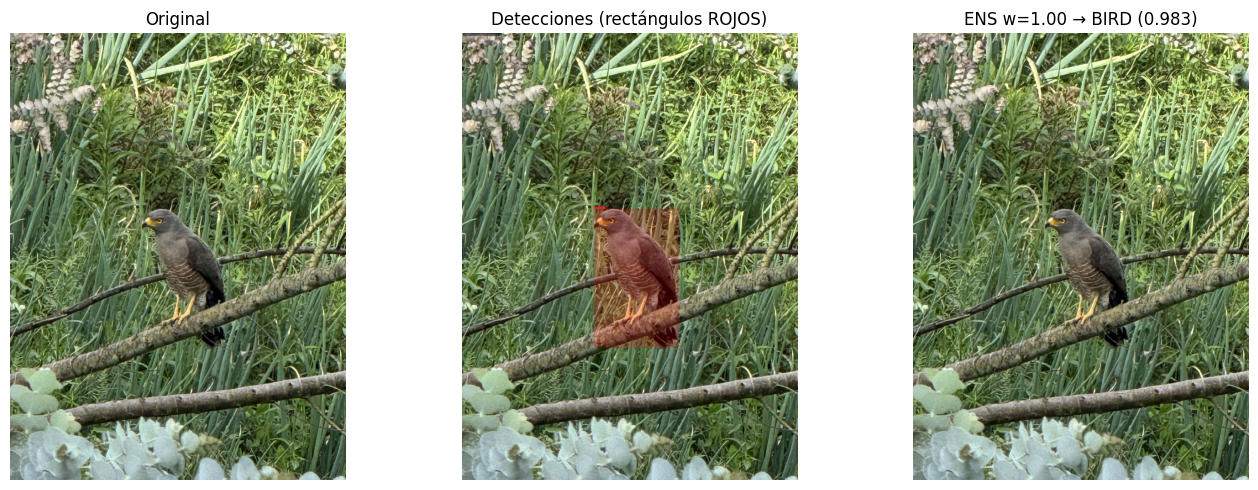

{'image': '/content/drive/MyDrive/openimages_v7/bird.png', 'size_wh': (3024, 4032), 'threshold': 0.8, 'yolo_count': 1, 'yolo_area_sum': 0.07842536828049063, 'ensemble_w': 1, 'ensemble_prob': 0.9834654331207275, 'cnn_label': 'bird', 'yolo_label': 'bird', 'ensemble_label': 'bird', 'device': 'cuda', 'boxes': [(1186.4501953125, 1590.4444580078125, 1951.9208984375, 2839.6396484375, np.float64(0.9489006400108337), 0.07842536828049063)]}


In [17]:
from pathlib import Path
from typing import Optional, Dict, Any
import numpy as np, torch, math
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from ultralytics import YOLO

_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
try: _bird_idx = bird_idx
except NameError: _bird_idx = 1

def _build_val_tf(img_size:int):
    try: return val_tf
    except NameError:
        from torchvision import transforms
        return transforms.Compose([
            transforms.Resize(int(img_size*1.1)),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])

@torch.no_grad()
def _cnn_prob(m: torch.nn.Module, img_pil: Image.Image, img_size:int) -> float:
    x = _build_val_tf(img_size)(img_pil).unsqueeze(0).to(_DEVICE)
    logits = (globals().get("tta3_logits")(m,x) if callable(globals().get("tta3_logits")) else m.eval()(x))
    probs = torch.softmax(logits, dim=1).squeeze(0).detach().cpu().numpy()
    return float(probs[_bird_idx])

def _yolo_on_image(img_path: Path, use_cpu: bool):
    yolo_device = "cpu" if use_cpu else (0 if torch.cuda.is_available() else "cpu")
    yolo_w = "yolov8x.pt" if (yolo_device!="cpu") else "yolov8n.pt"
    model = YOLO(yolo_w)
    if yolo_device!="cpu": model.to("cuda")
    r = model.predict(str(img_path), conf=0.01, iou=0.50, imgsz=960, agnostic_nms=True, verbose=False, device=yolo_device)[0]
    names = model.model.names if hasattr(model.model, "names") else model.names
    name_map = {int(k): str(v).lower() for k,v in (names.items() if isinstance(names, dict) else dict(enumerate(names)).items())}
    bird_ids = {cid for cid, cname in name_map.items() if "bird" in cname}
    boxes = []
    pmax, cnt, area_sum = 0.0, 0, 0.0
    W,H = r.orig_shape[1], r.orig_shape[0]
    if getattr(r, "boxes", None) is not None and len(r.boxes)>0:
        cls = r.boxes.cls.detach().cpu().numpy().astype(int)
        conf = r.boxes.conf.detach().cpu().numpy().astype(float)
        xyxy = r.boxes.xyxy.detach().cpu().numpy().astype(float)
        for i in range(len(cls)):
            if cls[i] in bird_ids:
                x1,y1,x2,y2 = xyxy[i].tolist()
                w = max(0.0, x2-x1); h = max(0.0, y2-y1)
                af = (w*h)/(W*H) if (W>0 and H>0) else 0.0
                boxes.append((x1,y1,x2,y2,conf[i],af))
                pmax = max(pmax, conf[i]); cnt += 1; area_sum += af
    return boxes, float(pmax), int(cnt), float(area_sum), (W,H)

def _text_size(dr, txt, font):
    try:
        if font and hasattr(font,"getbbox"):
            b = font.getbbox(txt); return b[2]-b[0], b[3]-b[1]
        if font and hasattr(font,"getsize"):
            return font.getsize(txt)
        if hasattr(dr,"textlength"):
            return int(dr.textlength(txt, font=font)), 16
    except: pass
    return 64, 16

def _draw_boxes_red(img_pil: Image.Image, boxes, headline:str=""):
    im = img_pil.convert("RGBA")
    overlay = Image.new("RGBA", im.size, (0,0,0,0))
    dr = ImageDraw.Draw(overlay)
    try: font = ImageFont.load_default()
    except: font = None
    for i,(x1,y1,x2,y2,cf,af) in enumerate(boxes, start=1):
        x1,y1,x2,y2 = map(float,(x1,y1,x2,y2))
        dr.rectangle([x1,y1,x2,y2], outline=(255,0,0,255), width=3)
        dr.rectangle([x1,y1,x2,y2], fill=(255,0,0,50))
        cx, cy = (x1+x2)/2, (y1+y2)/2
        dr.ellipse([cx-3,cy-3,cx+3,cy+3], fill=(255,255,255,230))
        txt = f"bird#{i} c={cf:.2f} a={af*100:.1f}%"
        tw, th = _text_size(dr, txt, font); pad=4
        bx1, by1 = x1, max(0, y1-th-2*pad)
        dr.rectangle([bx1,by1,bx1+tw+2*pad,by1+th+2*pad], fill=(255,0,0,220))
        dr.text((bx1+pad, by1+pad), txt, fill=(255,255,255,255), font=font)
    if headline:
        tw, th = _text_size(dr, headline, font); pad=6
        dr.rectangle([10,10,10+tw+2*pad,10+th+2*pad], fill=(0,0,0,180))
        dr.text((10+pad,10+pad), headline, fill=(255,255,255,230), font=font)
    return Image.alpha_composite(im, overlay).convert("RGB")

def predict_analyze_openimages(
    relative_path: str,
    threshold: float = 0.5,
    base_dir: Optional[str] = None,
    img_size: Optional[int] = None,
    w_cnn: float = 0.5,
    show: bool = False
) -> Dict[str, Any]:
    if "model" not in globals(): raise RuntimeError("model no encontrado")
    m = model.to(_DEVICE).eval()
    if base_dir is None: base_dir = str(globals().get("BASE","/content/drive/MyDrive/openimages_v7"))
    if img_size is None: img_size = int(globals().get("IMG_SIZE",384))
    p = Path(base_dir)/relative_path
    if not p.exists(): raise FileNotFoundError(p)
    img = Image.open(p).convert("RGB")

    p_cnn = _cnn_prob(m, img, img_size)
    boxes, p_yo, cnt, a_sum, (W,H) = _yolo_on_image(p, use_cpu=(not torch.cuda.is_available()))
    p_ens = float(w_cnn*p_cnn + (1.0-w_cnn)*p_yo)

    lab_cnn = "bird" if p_cnn>=threshold else "nobird"
    lab_yo  = "bird" if p_yo >=threshold else "nobird"
    lab_ens = "bird" if p_ens>=threshold else "nobird"

    headline = f"CNN={p_cnn:.3f}({lab_cnn})  YOLOmax={p_yo:.3f}({lab_yo})  Ens={p_ens:.3f}({lab_ens})  cnt={cnt}  Σa={a_sum*100:.1f}%"
    img_det = _draw_boxes_red(img, boxes, headline=headline if cnt>0 else "Sin detecciones de 'bird'")

    if show:
        fig = plt.figure(figsize=(14,5))
        gs = fig.add_gridspec(1,3)
        ax0 = fig.add_subplot(gs[0,0]); ax1 = fig.add_subplot(gs[0,1]); ax2 = fig.add_subplot(gs[0,2])
        ax0.imshow(img); ax0.set_title("Original"); ax0.axis("off")
        ax1.imshow(img_det); ax1.set_title("Detecciones (rectángulos ROJOS)"); ax1.axis("off")
        ax2.imshow(img); ax2.axis("off")
        ax2.set_title(f"ENS w={w_cnn:.2f} → {lab_ens.upper()} ({p_ens:.3f})")
        plt.tight_layout(); plt.show()

    return {
        "image": str(p),
        "size_wh": (W,H),
        "threshold": threshold,
        "yolo_count": cnt,
        "yolo_area_sum": a_sum,
        "ensemble_w": w_cnn,
        "ensemble_prob": p_ens,
        "cnn_label": lab_cnn,
        "yolo_label": lab_yo,
        "ensemble_label": lab_ens,
        "device": _DEVICE,
        "boxes": boxes
    }

# Ejemplo:
r = predict_analyze_openimages("bird.png", threshold=0.8, w_cnn=1, show=True); print(r)
